### Final Project Skeleton Code
This notebook is meant to be skeleton code for the final project. We have filled in the code to allow you to download the dataset and train your neural network on it. We have not made the neural network for you. All of the specifics, including layer sizes and hyperparameters, are up to you to decide. Some of this code may not work perfectly for you, so you will have to read it and understand what is going on so that you can create your neural network. The testing cell at the end is how we will be testing your neural networks, so be sure that whatever you do, it works with that cell. (For example: do any data processing such as flattening and padding in the forward function rather than in the testing loop as we will not be editing our testing loop to reflect any of those changes)

In [1]:
# !pip install torch

### Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

### Download training and testing data

In [84]:
#The line below gets the dataset and downloads it into the specified path
dataset = torchvision.datasets.MNIST('./mnist_data', download=True, train=True, transform=torchvision.transforms.ToTensor()) # consider how to separate this into multiple datasets


torch.manual_seed(0)
trainset, validset = torch.utils.data.random_split(dataset, [0.7, 0.3])

#PyTorch uses dataloaders which you can learn about here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#This is a convenient module for training, it automatically prepares your data for training with a given batch size.
#The shuffle argument will automatically randomize the order of your data (but will keep inputs with associated outputs!)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = False)

### Create dataloaders and visualize some examples

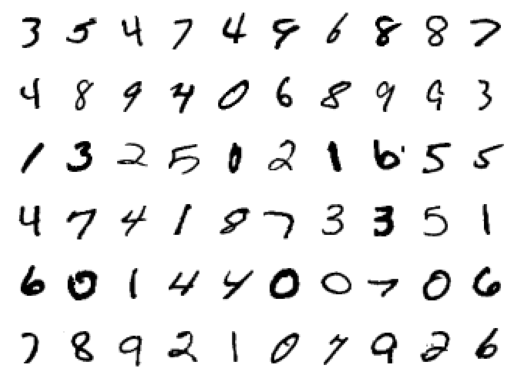

In [85]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print(images.shape)
# print(torch.flip(images, [3]))
# print(torchvision.transforms.functional.invert(images))
# print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Model Initialization

In [89]:
#This is your neural network class, so it must extend nn.Module
#For your final submission you will be submitting this cell as its own file
class Digit_Classifier(nn.Module):
  def __init__(self):
    #Handle some under-the-hood PyTorch stuff
    super().__init__()
    
    #Now put your layers below in addition to any other member variables you need
    #

  def forward(self, x):
    #Now here you add your forward pass, e.g. how the layers fit together
    #Tips:
    # 1. Don't forget the ReLU layer when needed
    # 2. Consider normalization
    # 3. If you are getting errors look at your dimensions, dimension errors are very easy to make!
    # 4. CNN layers take in rectangular (or square) inputs and give rectangular (or square) outputs. Fully connected layers have input and output that are vectors, when you need to switch between the two consider using a flatten or reshape
    pass

  #Optional: any other member functions that you think would be helpful

In [90]:
#Instantiate your model:
model = Digit_Classifier()

### Hyperparameters Tuning

In [93]:
#hyperparameters: currently all are set to 1, it is up to you to figure out what they should be
#Don't just randomly change the hyperparameters: consider what each of them are changing (look in the code to find where the actually affect things)
num_epochs = 1
learning_rate = 1
momentum = 1
criterion = nn.L1Loss() #consider using these loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) #consider using these optimizers: https://pytorch.org/docs/stable/optim.html#algorithms

ValueError: optimizer got an empty parameter list

### Model Training

In [115]:
#Consider how you will keep track of losses, it would be great to have graphs of your loss over time in your final presentation
running_loss = []

horiz_flipped = [(torch.flip(images, [3]), labels) for images, labels in trainloader]
inverted = [(torchvision.transforms.functional.invert(images), labels) for images, labels in trainloader]

combined_data = [(images, labels) for images, labels in trainloader] + horiz_flipped + inverted

#Training loop
model.train()
for i in range(num_epochs):
  # for images, labels in trainloader:
  for images, labels in combined_data:
    pass
    # do any preprocessing, for example flattening if needed
    
    # print(torch.flip(images, [3]))
    # print(torchvision.transforms.functional.invert(images))

    #zero out the gradients

    #Calculate the output

    #Calculate the loss of the output, note: labels are the ACTUAL image labels, whereas output are your models guesses

    #Backpropagation (this is the part where we take the gradients [multivariable derivatives] of all the weights)

    #This is the part where we actually update the weights: how is learning_rate related to this step?

    #Consider adding some checking here to see how your loss has been doing over time, this will save you a lot of time if you can notice immediate issues
    #While this is not required it is HIGHLY recommended, try to do it yourself but reach out if you need help

1971


### Save your model

In [ ]:
#Save your model weights (this will generate a file that you will have to submit to us)
torch.save(model.state_dict(), 'PATH_TO_WHERE_YOU_WANT_TO_SAVE/weights.pth')

### Evaluate Test Accuracy

In [ ]:
model.eval()
correct = 0
total = 0

#ensure gradients won't get changed
with torch.no_grad():
  for images, labels in testloader:
    for i in range(len(labels)):
      #do any preprocessing

      #calculate the output
      output = model(images[i])

      predicted_label = output.index(max(output))

      if predicted_label == labels[i]:
        correct += 1
      total += 1

print("Test accuracy: ", correct/total)